### Install and import packages

In [57]:
# Install packages
!pip install bayes_logistic

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats

import bayes_logistic

### Set parameters

In [109]:
# Set parameters
# num_data
num_data_half = 100
num_data = num_data_half*2
num_feats = 1

# num_samples 
num_samples = 1000

# data_x marginal distribution parameters
data_x_marginal_params = [
    [[-1.0], [1.0]],
    [[5.0], [2.0]]
]

# weights prior distribution parameters
weights_prior_params = [[0.0], [1.1]]

# init sigma used in numerical optimization for laplace approximation
laplace_init_sigma = 10



### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= [c_0\_x, c_1\_x]\\
  c_0\_x &\sim p(x|\mu_0, \sigma_0^2) \\
  c_1\_x &\sim p(x|\mu_1, \sigma_1^2)
\end{align*}
$$


In [97]:
# Generate data_x
np.random.seed(0)

data_x_marginal_dists = [
    stats.multivariate_normal(mu, sigma) \
        for mu, sigma in data_x_marginal_params]

c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))[:,None]
c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))[:,None]
data_x = np.vstack((c0_x, c1_x))

In [102]:
print(data_x.shape)

(200, 1)


### Sample weights, generate sample y from sample weights and visualize data

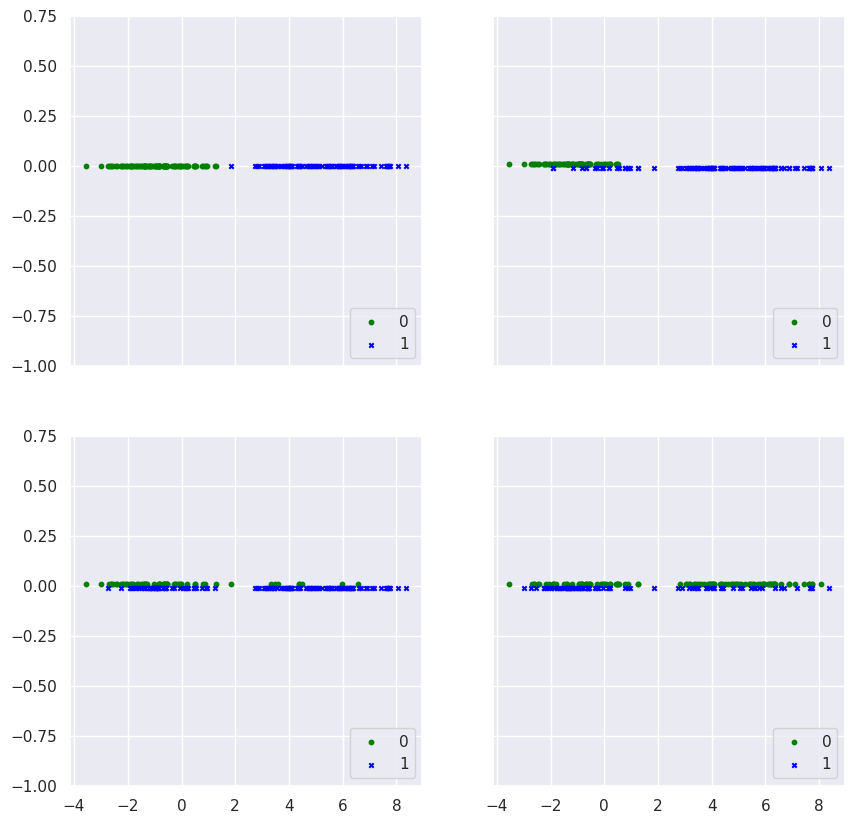

In [104]:
# Sample weights, generate sample data_y, and plot sample data

# plot data_x according to pre-defined classes 
fig, axes = plt.subplots((num_samples+1)//2, 2, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()
# sns.kdeplot(data_x.squeeze(-1), shade=False, ax=axes[0])
axes[0].scatter(data_x[:num_data_half], np.zeros(num_data_half), color=color_list[0], label=0, s=10, marker="o")
axes[0].scatter(data_x[num_data_half:], np.zeros(num_data_half), color=color_list[1], label=1, s=10, marker="x")
axes[0].legend(loc="lower right")

# sample weights and generate sample y according to the weights, and plot 
weights_prior_dist = stats.multivariate_normal(weights_prior_params[0], weights_prior_params[1])

num_samples = 3
np.random.seed(0) # reset random generator
for i in range(num_samples):
    # sample weights
    sample_weights_prior = weights_prior_dist.rvs(1)
    
    # generate sample data_y
    sample_logit = 1.0 / (1 + np.exp(-np.dot(data_x, sample_weights_prior)))
    sample_y = stats.bernoulli.rvs(sample_logit)
     
    axes[i+1].scatter(data_x[sample_y==0], np.ones_like(data_x[sample_y==0])*0.01, 
                      color=color_list[0], label=0, s=10, marker="o")
    axes[i+1].scatter(data_x[sample_y==1], np.ones_like(data_x[sample_y==1])*(-0.01), 
                      color=color_list[1], label=1, s=10, marker="x")
    axes[i+1].legend(loc="lower right")

plt.yticks(np.arange(-1, 1, step=0.25))
plt.show()
    

#### Comments on the plots
1. Even though the data_x is set to be linearly separable, using random prior weights can lead to linearly nonseparable cases.

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [110]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)


samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
for i in range(num_samples):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.dot(data_x, sample_a_weights_prior)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(sample_a_y.shape)
    
    # fit laplace approximation
    w_map, h_map = bayes_logistic.fit_bayes_logistic(
        y = sample_a_y.squeeze(-1),
        X = data_x, 
        wprior = sample_a_weights_prior, # note: init prior for laplace approximation is same assample prior
        # wprior = np.zeros(num_feats),
        H = ((np.identity(num_feats)) * laplace_init_sigma),
        weights = None,
        solver = "Newton-CG",
        bounds = None,
        maxiter = 1000
    )
    cov_map = np.linalg.inv(h_map)
    
    # sample weights' posterior
    sample_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map)
    samples_a_weights_posterior.append(sample_a_weights_posterior)    

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior)
# print(samples_a_weights_posterior)

(1000, 1)


In [55]:
# print(sample_a_weights_prior)
# print(cov_map)

### Visualize the generated prior and posterior samples 

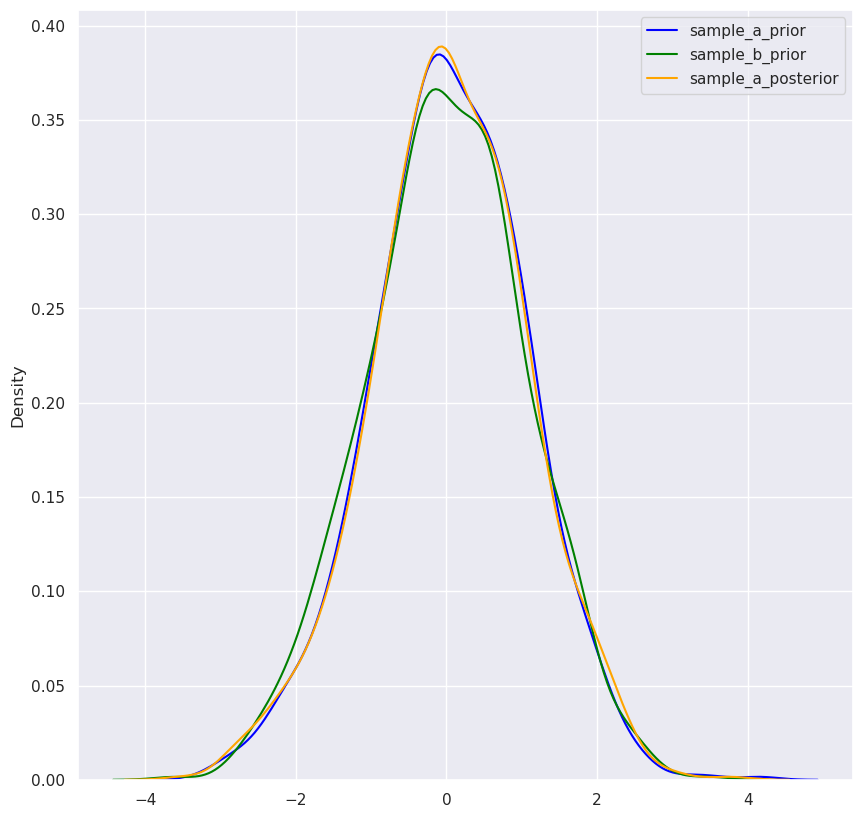

In [111]:

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,10))
# axes = axes.flatten()

sns.kdeplot(samples_a_weights_prior[:,0], shade=False, color="blue", label="sample_a_prior", ax=axes)
sns.kdeplot(samples_b_weights_prior[:,0], shade=False, color="green", label="sample_b_prior", ax=axes)
sns.kdeplot(samples_a_weights_posterior[:,0], shade=False, color="orange", label="sample_a_posterior", ax=axes)
plt.legend()
plt.show()

#### Comments on the plots
1. The samples_a_prior seems to closer to samples_a_posterior than samples_prior? (not sure)

[]

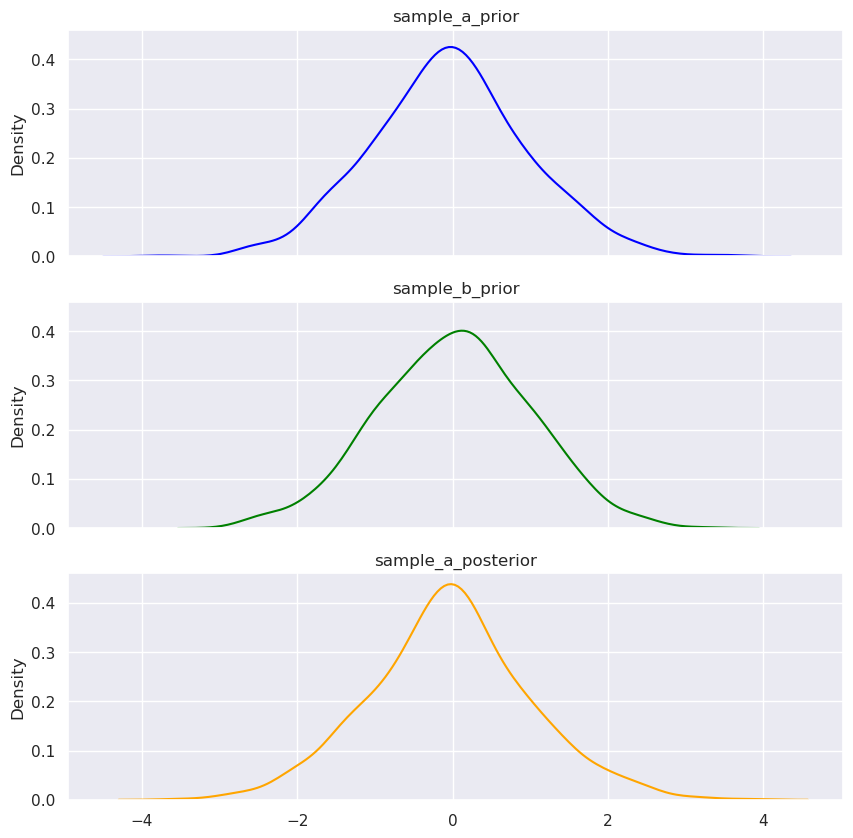

In [95]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(samples_a_weights_prior[:,0], shade=False, color="blue", label="sample_a_prior", ax=axes[0])
sns.kdeplot(samples_b_weights_prior[:,0], shade=False, color="green", label="sample_b_prior", ax=axes[1])
sns.kdeplot(samples_a_weights_posterior[:,0], shade=False, color="orange", label="sample_a_posterior", ax=axes[2])
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.plot()